# Section 0: Import section

In [15]:
# pytorch 
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.functional import normalize
from torch.utils.data import DataLoader, TensorDataset

# Helper funcitons and classes
from helper_func_and_classes import create_dataset_list, create_submission_file, create_vocab
from helper_func_and_classes import split_dataset
from helper_func_and_classes import word_vec_to_aggregated_word_embeddings
from helper_func_and_classes import TwitterDataset
from helper_func_and_classes import get_count_of_longest_sentence
from helper_func_and_classes import output_numpy_array_from_model_training
from helper_func_and_classes import output_numpy_array_from_model_submission

# word embeddings
from torchtext.vocab import GloVe

# scikit-learn
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# plotting 
import matplotlib.pyplot as plt

#data science
from tqdm import tqdm
import time

# random state
RANDOM_SEED = 123 # used in helper functions

# Section 1: Data preprocessing section
This section will extract the data from the three different .txt files. Then, the helper functions will process the tweets to create our vocabulary and three python lists for positive, negative, and submission tweets. The tweets are pre tokenized, so we only split on white space.

In [2]:
# creating the text vocabulary from the whole data set, including positive, negative and test data.
text_vocab_full = create_vocab("./twitter-datasets/train_pos_full.txt",
                          "./twitter-datasets/train_neg_full.txt",
                          "./twitter-datasets/test_data.txt")

text_vocab_lite = create_vocab("./twitter-datasets/train_pos.txt",
                          "./twitter-datasets/train_neg.txt",
                          "./twitter-datasets/test_data.txt")

# creating a standard python library list of the tweets that will be used for submission, 1 tweet per index
submission_data = create_dataset_list("./twitter-datasets/test_data.txt")

print("Length of text_vocab_full: ", len(text_vocab_full))
print("Length of text_vocab_lite: ", len(text_vocab_lite))
print("Length of submission_data: ",len(submission_data))

100%|████████████████████| 10000/10000 [00:00<00:00, 745879.47it/s]


Length of text_vocab_full:  604014
Length of text_vocab_lite:  127802
Length of submission_data:  10000


Here we will create the TwitterDataset class which contains all the pre processed data, here we do not have any cutoff since we can have any length for the quotes since they are just aggregated over the same dimensions.

Furthermore we will split and shuffle the dataset into training and testing. The longest sentences is also located by using the get_count_of_longest_sentence on the dataset.

In [3]:
# Creating the dataset in the TwitterDataset class which is found in the helper functions
dataset_full = TwitterDataset(text_vocab_full,
                              create_dataset_list("./twitter-datasets/train_pos_full.txt"),
                              create_dataset_list("./twitter-datasets/train_neg_full.txt"),
                              submission_data,
                              1000)

dataset_lite = TwitterDataset(text_vocab_lite, 
                              create_dataset_list("./twitter-datasets/train_pos.txt"),
                              create_dataset_list("./twitter-datasets/train_neg.txt"),
                              submission_data,
                              1000)

# create training dataset and test dataset - using a split of 85% / 15%
train_dataset_full, test_dataset_full = split_dataset(dataset_full, 0.9);
train_dataset_lite, test_dataset_lite = split_dataset(dataset_lite, 0.9);

# calculating the longest sentence
max_len_full = get_count_of_longest_sentence(dataset_full)
max_len_lite = get_count_of_longest_sentence(dataset_lite)

100%|██████████████████| 100000/100000 [00:00<00:00, 146299.59it/s]


Number of elements in train_data is:  2250000
Number of elements in test_data is:  250000
Number of elements in train_data is:  180000
Number of elements in test_data is:  20000


# Section 2: Neural network
#### Pretrained word embeddings (dim=200) 
Here we will use pre-trained Global Vector word embeddings (Glove); these will have a dimension of 200 per word. The pre-trained word embeddings were downloaded from https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html#GloVe. The word embedding used has been trained on Twitter data, which will increase accuracy since our corpus also consists of Twitter data.

In [4]:
batch_size = 16
glove_vec = GloVe(name='twitter.27B', dim=200)

In [5]:
word_embeddings_lite = glove_vec.get_vecs_by_tokens(list(text_vocab_lite.keys()), lower_case_backup=True)
word_embeddings_full = glove_vec.get_vecs_by_tokens(list(text_vocab_full.keys()), lower_case_backup=True)

In [6]:
# full version of dataset used for training the model
matrix_train_full, labels_train_full = word_vec_to_aggregated_word_embeddings(train_dataset_full, word_embeddings_full, 200)
#scaled_matrix_train_full = torch.tensor(scale(matrix_train_full)).type(torch.float)
matrix_train_full_tensor = torch.tensor(matrix_train_full).type(torch.float)
scaled_matrix_train_full = normalize(matrix_train_full_tensor, p=1.0, dim =-1)


matrix_test_full, labels_test_full = word_vec_to_aggregated_word_embeddings(test_dataset_full, word_embeddings_full, 200)
#scaled_matrix_test_full = torch.tensor(scale(matrix_test_full)).type(torch.float)
matrix_test_full_tensor = torch.tensor(matrix_test_full).type(torch.float)
scaled_matrix_test_full = normalize(matrix_test_full_tensor, p=1.0, dim =-1)


# small version of dataset used for param optimizing
matrix_train_lite, labels_train_lite = word_vec_to_aggregated_word_embeddings(train_dataset_lite, word_embeddings_lite, 200)
#scaled_matrix_train_lite = torch.tensor(scale(matrix_train_lite)).type(torch.float)
matrix_train_lite_tensor = torch.tensor(matrix_train_lite).type(torch.float)
scaled_matrix_train_lite = normalize(matrix_train_lite_tensor, p=1.0, dim =-1)

matrix_test_lite, labels_test_lite = word_vec_to_aggregated_word_embeddings(test_dataset_lite, word_embeddings_lite, 200)
#scaled_matrix_test_lite = torch.tensor(scale(matrix_test_lite)).type(torch.float)
matrix_test_lite_tensor = torch.tensor(matrix_test_lite).type(torch.float)
scaled_matrix_test_lite = normalize(matrix_test_lite_tensor, p=1.0, dim =-1)

2250000it [02:10, 17277.37it/s]
/var/folders/pc/5ytjzw0165n86jc4_pv2802c0000gn/T/ipykernel_82441/415349543.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_train_full_tensor = torch.tensor(matrix_train_full).type(torch.float)
250000it [00:23, 10458.49it/s]
/var/folders/pc/5ytjzw0165n86jc4_pv2802c0000gn/T/ipykernel_82441/415349543.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_test_full_tensor = torch.tensor(matrix_test_full).type(torch.float)
180000it [00:11, 15705.92it/s]
/var/folders/pc/5ytjzw0165n86jc4_pv2802c0000gn/T/ipykernel_82441/415349543.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

In [7]:
print("Shape of scaled_matrix_train_full: ", scaled_matrix_train_full.shape)
print("Shape of scaled_matrix_test_full: ", scaled_matrix_test_full.shape)
print("Shape of scaled_matrix_train_lite: ", scaled_matrix_train_lite.shape)
print("Shape of scaled_matrix_test_lite: ", scaled_matrix_test_lite.shape)

Shape of scaled_matrix_train_full:  torch.Size([2250000, 200])
Shape of scaled_matrix_test_full:  torch.Size([250000, 200])
Shape of scaled_matrix_train_lite:  torch.Size([180000, 200])
Shape of scaled_matrix_test_lite:  torch.Size([20000, 200])


In [16]:
# best model for GloVE and current best
class NN(nn.Module):
    def __init__(self, input_size, num_classes, p):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc9 = nn.Linear(200, num_classes)
        self.dropout1 = nn.Dropout(p) 
        self.batchnorm1 = nn.BatchNorm1d(200)
        self.batchnorm2 = nn.BatchNorm1d(200)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout1(x)
        x = self.fc9(x)
        
        
        return x 

## Sentence embeddings

In [17]:
# full version of dataset used for training the model
labels_train_full = labels_train_full.type(torch.LongTensor) # can't be float
labels_test_full = labels_test_full.type(torch.LongTensor) # can't be float

# already shuffled
train_dataset_full = TensorDataset(scaled_matrix_train_full, labels_train_full)
train_loader_full = DataLoader(dataset=train_dataset_full, batch_size=batch_size,  shuffle=False)
test_dataset_full = TensorDataset(scaled_matrix_test_full, labels_test_full)
test_loader_full = DataLoader(dataset=test_dataset_full, batch_size=batch_size,  shuffle=False)


# small version of dataset used for param optimizing
labels_train_lite = labels_train_lite.type(torch.LongTensor) # can't be float
labels_test_lite = labels_test_lite.type(torch.LongTensor) # can't be float

# already shuffled
train_dataset_lite = TensorDataset(scaled_matrix_train_lite, labels_train_lite)
train_loader_lite = DataLoader(dataset=train_dataset_lite, batch_size=batch_size,  shuffle=False)
test_dataset_lite = TensorDataset(scaled_matrix_test_lite, labels_test_lite)
test_loader_lite = DataLoader(dataset=test_dataset_lite, batch_size=batch_size,  shuffle=False)

## Section 2.1: Choosing best parameters

In [22]:
# Finding best parameters for neural network
input_dim = 200
num_classes = 2
epoch_options = [3, 5]
lr_options = [1e-4, 1e-3, 1e-2]
drop_options = [0.1, 0.45, 0.55, 0.65]

all_options = []
for i in epoch_options:
    for j in lr_options:
        for k in drop_options:
             all_options.append([i,j,k])
                
precision_list = []
recall_list = []
f1score_list = []
support_list = []

In [28]:
%%time

for epoch_i, lr_i, drop_i in all_options:
    start_time = time.time()
    print(f"Epoch: {epoch_i} | Learning rate: {lr_i} | Dropout probability: {drop_i}")
    
    model = NN(input_size=input_dim, num_classes=num_classes, p=drop_i)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr_i)
    for epoch in range(epoch_i):
        for data, labels in train_loader_lite:

            model_score = model(data)
            loss = criterion(model_score, labels)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
    
    
    # creating status report for current iteration
    predicted_labels = output_numpy_array_from_model_training(test_loader_lite, model)
    
    class_report = classification_report(labels_test_lite, predicted_labels, output_dict=True)['macro avg']
    
    # appending results to corresponding list
    precision_list.append(class_report['precision'])
    recall_list.append(class_report['recall'])
    f1score_list.append(class_report['f1-score'])
    support_list.append(class_report['support'])
    print("Time of current iteration: ", time.time()-start_time)
    print(class_report, "\n")

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.1
Time of current iteration:  75.16151881217957
{'precision': 0.7990987216550399, 'recall': 0.7987497059846744, 'f1-score': 0.7987296177600345, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.45
Time of current iteration:  76.61768078804016
{'precision': 0.7922527366730066, 'recall': 0.791737548597842, 'f1-score': 0.7916936054259074, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.55
Time of current iteration:  77.58521103858948
{'precision': 0.7903077012903603, 'recall': 0.789627608321316, 'f1-score': 0.7895599226669241, 'support': 20000} 

Epoch: 3 | Learning rate: 0.0001 | Dropout probability: 0.65
Time of current iteration:  89.15863108634949
{'precision': 0.788182094060524, 'recall': 0.7874758826432322, 'f1-score': 0.7874023886950247, 'support': 20000} 

Epoch: 3 | Learning rate: 0.001 | Dropout probability: 0.1
Time of current iteration:  79.6990909576416
{'precis

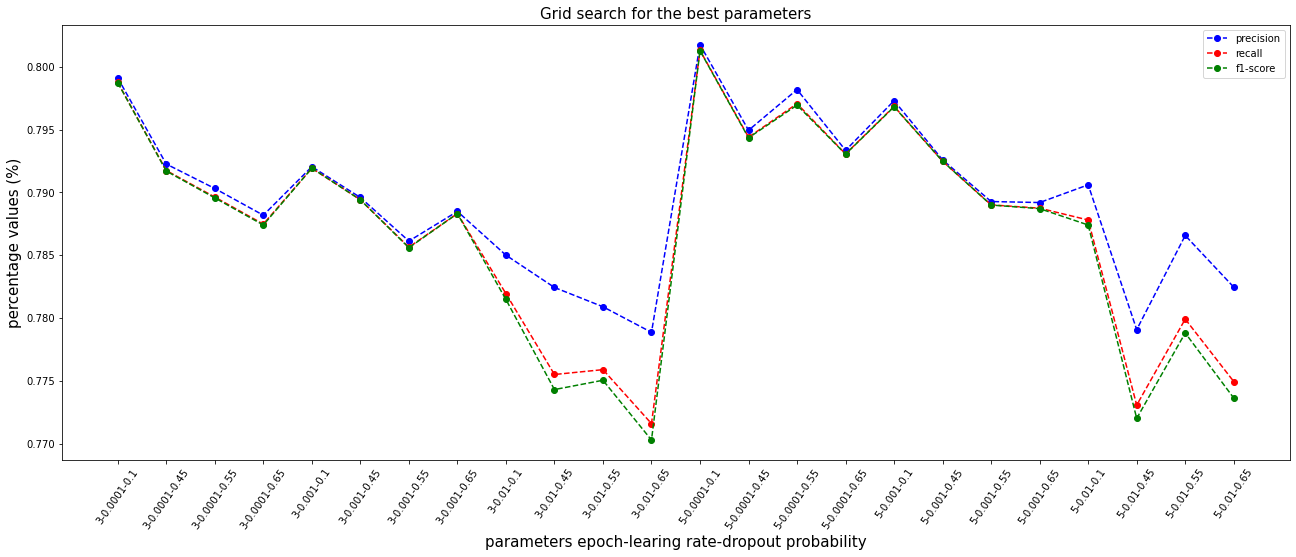

In [29]:
all_options_str = [f"{a}-{b}-{c}" for a,b,c in all_options]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.rcParams["figure.figsize"] = (22,8)

plt.xticks(rotation='55', fontsize=10)
ax.plot(all_options_str, precision_list, linestyle='--', marker='o', color='blue', label='precision')
ax.plot(all_options_str, recall_list, linestyle='--', marker='o', color='red', label='recall')
ax.plot(all_options_str, f1score_list, linestyle='--', marker='o', color='green', label='f1-score')
plt.title("Grid search for the best parameters", fontsize=15)
plt.xlabel("parameters epoch-learing rate-dropout probability", fontsize=15)
plt.ylabel("percentage values (%)", fontsize=15)

plt.legend()
plt.show();

In [33]:
input_dim = 200
num_classes = 2
learning_rate = 0.0001
num_epochs = 5
drop_probability = 0.1

In [34]:
model = NN(input_size=input_dim, num_classes=num_classes, p=drop_probability)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)

for epoch in range(epoch_i):
    for data, labels in tqdm(train_loader_full):

        model_score = model(data)
        loss = criterion(model_score, labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

 84%|█████████████████▋   | 118167/140625 [04:10<00:42, 523.13it/s]

In [ ]:
predicted_labels = output_numpy_array_from_model_training(test_loader_full, model)
print(classification_report(labels_test_full, predicted_labels))

# Section 3: Creating submission

In [ ]:
submission_matrix, id_submission_matrix = word_vec_to_aggregated_word_embeddings(
    dataset_full.submission_dataset,
    word_embeddings_full,
    200)
submission_matrix_tensor = torch.tensor(submission_matrix).type(torch.float)
scaled_submission_matrix = normalize(submission_matrix_tensor, p=1.0, dim =-1)
submission_dataset = TensorDataset(scaled_submission_matrix, torch.tensor(id_submission_matrix).type(torch.float))
submission_loader = DataLoader(dataset=submission_dataset, batch_size=batch_size,  shuffle=False)

submission_numpy_array = output_numpy_array_from_model_training(submission_loader, model)
submission_numpy_array

In [ ]:
create_submission_file(submission_numpy_array)